<a href="https://www.kaggle.com/code/tanishjain1403/pc-detection-yolov8n?scriptVersionId=136530184" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-pc-detection/detector.yaml
/kaggle/input/pc-setup-detector-dataset/final/labels/val/84.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/383.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/115.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/127.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/356.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/155.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/398.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/299.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/253.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/151.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/51.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/373.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/323.txt
/kaggle/input/pc-setup-detector-dataset/final/labels/val/88.txt
/kaggle/input/pc-setup-detector-dataset/final/l

In [2]:
import torch
from IPython.display import Image
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [3]:
mapping = {
    "Phone/Tablet":0,
    "Laptop": 1,
    "TV/Monitor": 2,
    "Keyboard": 3,
    "Mouse":4
}

In [4]:
!cp -R /kaggle/input/pc-setup-detector-dataset /kaggle/working/

In [5]:
ann_path ="/kaggle/working/pc-setup-detector-dataset/final/labels/train"
annotations = [os.path.join(ann_path, x) for x in os.listdir(ann_path) if x[-3:]=="txt"]

/kaggle/working/pc-setup-detector-dataset/final/images/train/68.png /kaggle/working/pc-setup-detector-dataset/final/labels/train/68.txt


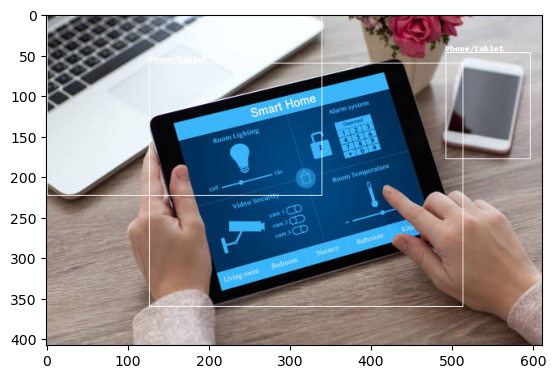

In [6]:
random.seed(1000)
class_id_to_name = dict(zip(mapping.values(), mapping.keys()))

def plot_bbox(img, ann_list):
    annotations = np.array(ann_list)
    w,h = img.size
    
    plotted_img = ImageDraw.Draw(img)
    
    plotted_image = ImageDraw.Draw(img)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0, y0), (x1, y1)))
        plotted_image.text((x0, y0-10), class_id_to_name[(int(obj_cls))])
    plt.imshow(np.array(img))
    plt.show()

annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    ann_list = file.read().split("\n")[:-1]
    ann_list = [x.split(" ") for x in ann_list]
    ann_list = [[float(y) for y in x] for x in ann_list]

img_file = annotation_file.replace("labels", "images").replace("txt", "png")
print(img_file, annotation_file)
assert os.path.exists(img_file)
img = Image.open(img_file)
plot_bbox(img, ann_list)

In [7]:
!git clone https://github.com/ultralytics/yolov3.git

Cloning into 'yolov3'...
remote: Enumerating objects: 10729, done.
remote: Counting objects: 100% (651/651), done.
remote: Compressing objects: 100% (338/338), done.
remote: Total 10729 (delta 419), reused 506 (delta 312), pack-reused 10078
Receiving objects: 100% (10729/10729), 9.81 MiB | 24.55 MiB/s, done.
Resolving deltas: 100% (7218/7218), done.


In [8]:
import yaml

with open(r'/kaggle/input/data-pc-detection/detector.yaml') as file:
    list = yaml.load(file, Loader=yaml.FullLoader)
    print(list)

{'train': '/kaggle/working/pc-setup-detector-dataset/final/images/train', 'val': '/kaggle/working/pc-setup-detector-dataset/final/images/val', 'test': '/kaggle/working/pc-setup-detector-dataset/final/images/test', 'nc': 5, 'names': ['Phone/Tablet', 'Laptop', 'TV/Monitor', 'Keyboard', 'Mouse']}


In [9]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api_key")
wandb.login(key = secret_value_0)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [10]:
!pip install ultralytics
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Use the model
results = model.train(data="/kaggle/input/data-pc-detection/detector.yaml", epochs=200)  # train the model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 627.5/627.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128